# Training on Audio-only MFCC features

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.models as models
from tensorflow.keras.utils import to_categorical
from classificationreport import ClassificationReport ## this is a python script provided in the directory

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import matplotlib
import subprocess
import os
import csv
import statistics
from sklearn.utils import resample



First, we import the saved MFCCs numpy train and test files and the full train and test dataframes to obtain the labels.

In [6]:
x_train_mfcc = np.load('/content/drive/MyDrive/emotion/train_mfccs.npy')
x_test_mfcc = np.load('/content/drive/MyDrive/emotion/test_mfccs.npy')

x_train_mfcc.shape, x_test_mfcc.shape

((9988, 40, 107), (2610, 40, 107))

In [7]:
train_df = pd.read_csv("/content/drive/MyDrive/emotion/train_sent_emo.csv", encoding='latin1')
test_df = pd.read_csv("/content/drive/MyDrive/emotion/test_sent_emo.csv", encoding='latin1')

train_df.shape, test_df.shape

((9988, 11), (2610, 11))

The emotions are labeled by any of these seven emotions -- Anger, Disgust, Sadness, Joy, Neutral, Surprise and Fear. Machine learning models typically work with numerical data, so we need to do Label encoding which converts categorical labels into numeric values, allowing the model to process and learn from them.

In [8]:
le = LabelEncoder()

train_df['emotion_encoded'] = le.fit_transform(train_df['Emotion'])
test_df['emotion_encoded'] = le.transform(test_df['Emotion'])
class_names_encoded = le.classes_

y_train = train_df['Emotion']
y_train_encoded = train_df['emotion_encoded']

y_test = test_df['Emotion']
y_test_encoded = test_df['emotion_encoded']

CNNs typically expect input data to have a specific shape that includes dimensions for the height, width, and channels of the input image. Hence, we expand the dimensions to match this required input shape.

In [9]:
train_X = np.expand_dims(x_train_mfcc, -1)
test_X = np.expand_dims(x_test_mfcc, -1)

Finally, we convert the encoded labels to one-hot encoding since we are dealing with a multiclass classification problem.

In [10]:
train_Y = to_categorical(np.array(y_train_encoded))
test_Y = to_categorical(np.array(y_test_encoded))

In [11]:
class_names_encoded.shape

(7,)

In [12]:
train_X[0].shape

(40, 107, 1)

The aim of extracting the mel-bin spectrograms and MFCCs is to convert an audio file into an image form and then use it as input in any image classification model.
<br>
The architecture of our model is given  - 
<br>
We use several layers to extract features from the input image (image of features extracted from an audio segment) and make predictions. The layers include convolutional layers, batch normalization, activation functions (ReLU), max pooling, and dropout for regularization. These layers are repeated multiple times, gradually increasing the number of filters. The final layers include flattening the feature maps, fully connected dense layers, and dropout regularization. The output layer uses the softmax activation function since our task is a multiclass classification problem. 

In [76]:
inputLayer = Input(shape=train_X[0].shape)

CONV = Conv2D(32, kernel_size=(7, 7), padding='same')(inputLayer)
CONV = BatchNormalization(axis=1)(CONV)
CONV = Activation('relu')(CONV)
CONV = MaxPooling2D(pool_size=2)(CONV)
CONV = Dropout(0.2)(CONV)

CONV = Conv2D(64, kernel_size=(7, 7), padding='same')(CONV)
CONV = BatchNormalization(axis=1)(CONV)
CONV = Activation('relu')(CONV)
CONV = MaxPooling2D(pool_size=2)(CONV)
CONV = Dropout(0.20)(CONV)

CONV = Conv2D(128, kernel_size=(7, 7), padding='same')(CONV)
CONV = BatchNormalization(axis=1)(CONV)
CONV = Activation('relu')(CONV)
CONV = MaxPooling2D(pool_size=2)(CONV)
CONV = Dropout(0.20)(CONV)

CONV = Conv2D(256, kernel_size=(7, 7), padding='same')(CONV)
CONV = BatchNormalization(axis=1)(CONV)
CONV = Activation('relu')(CONV)
CONV = MaxPooling2D(pool_size=2)(CONV)
CONV = Dropout(0.20)(CONV)

FLATTEN = Flatten()(CONV)
DENSE = Dense(100, activation='relu')(FLATTEN)
DROPOUT = Dropout(0.20)(DENSE)
    
outputLayer = Dense(7, activation='softmax')(DROPOUT)

classification_model = Model(inputLayer, outputLayer)

print(classification_model.summary())

classification_model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy']) 

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 40, 107, 1)]      0         
                                                                 
 conv2d_74 (Conv2D)          (None, 40, 107, 32)       1600      
                                                                 
 batch_normalization_74 (Bat  (None, 40, 107, 32)      160       
 chNormalization)                                                
                                                                 
 activation_70 (Activation)  (None, 40, 107, 32)       0         
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 20, 53, 32)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 20, 53, 32)        0   

In [77]:
tf.config.run_functions_eagerly(True)

Since the zip file of the validation set provided with the MELD dataset was corrupted, we created our own validation split from the train data.

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(train_X, train_Y, test_size=0.2, random_state=42)

In [79]:
type = 'speech_cnn_nodownsample'

We use checkpoints and early stopping to ensure that the model stops training before it starts to overfit on the training data.

In [80]:
checkpoint = ModelCheckpoint(type + '.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
es = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience=10, mode = "max", restore_best_weights = True, verbose=1)

In [81]:
model = classification_model.fit(X_train, Y_train, batch_size=32, epochs=100, callbacks=[es, checkpoint],
                                verbose=1, validation_data=(X_valid, Y_valid), shuffle=True)

Epoch 1/100
250/250 [==============================] - ETA: 0s - loss: 1.6403 - accuracy: 0.4433
Epoch 1: val_accuracy improved from -inf to 0.46897, saving model to speech_cnn_nodownsample.h5
250/250 [==============================] - 27s 106ms/step - loss: 1.6403 - accuracy: 0.4433 - val_loss: 1.5694 - val_accuracy: 0.4690
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 1.5628 - accuracy: 0.4641
Epoch 2: val_accuracy did not improve from 0.46897
250/250 [==============================] - 26s 104ms/step - loss: 1.5628 - accuracy: 0.4641 - val_loss: 1.5336 - val_accuracy: 0.4690
Epoch 3/100
250/250 [==============================] - ETA: 0s - loss: 1.5549 - accuracy: 0.4675
Epoch 3: val_accuracy improved from 0.46897 to 0.46947, saving model to speech_cnn_nodownsample.h5
250/250 [==============================] - 26s 106ms/step - loss: 1.5549 - accuracy: 0.4675 - val_loss: 1.4916 - val_accuracy: 0.4695
Epoch 4/100
250/250 [==============================] - ETA: 0

The Loss and Accuracy of the trained model on the test set is given below - 

In [ ]:
test_loss, test_acc = model.evaluate(test_X, test_Y)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

82/82 [==============================] - 2s 27ms/step - loss: 1.5671 - accuracy: 0.4862
Test loss: 1.5670850276947021
Test accuracy: 0.48620688915252686


In [ ]:
y_pred = model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)

82/82 [==============================] - 1s 15ms/step


In [ ]:
y_test_encoded = np.argmax(test_Y, axis=1)

In [ ]:
print(classification_report(y_test_encoded, y_pred, target_names=class_names_encoded))

              precision    recall  f1-score   support

       anger       0.32      0.18      0.23       345
     disgust       0.00      0.00      0.00        68
        fear       0.00      0.00      0.00        50
         joy       0.24      0.01      0.02       402
     neutral       0.51      0.94      0.66      1256
     sadness       0.33      0.01      0.03       208
    surprise       0.30      0.08      0.12       281

    accuracy                           0.49      2610
   macro avg       0.24      0.17      0.15      2610
weighted avg       0.38      0.49      0.37      2610



Since the support of 'neutral' utterences are overwhelmingly high, the model misclassifes most of the other classes as 'neutral'.

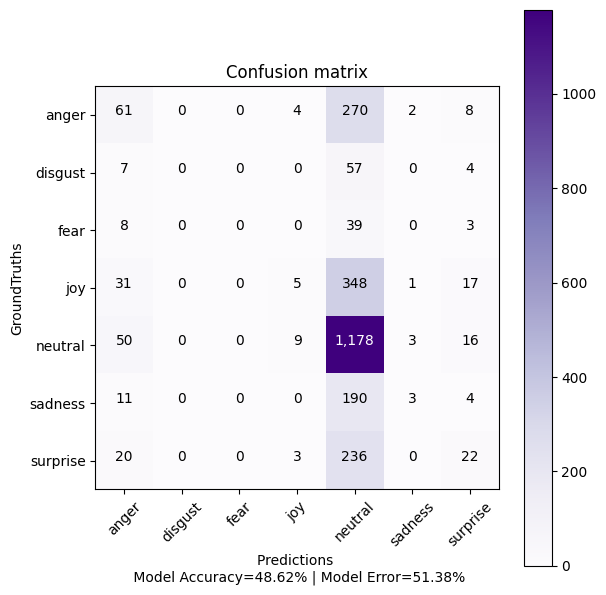

In [ ]:
cm = confusion_matrix(y_test_encoded, y_pred)
cr = ClassificationReport()
cr.plot_confusion_matrix(cm=cm, normalize = False, target_names = class_names_encoded)

## Prediction using ResNet50

In an attempt to improve the model performance, we also experimented with the ResNet50 model for our audio features.

In [14]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
     

In [15]:
def res_identity(x, filters): 
  x_skip = x 
  f1, f2 = filters

  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [16]:
def res_conv(x, s, filters):
  x_skip = x
  f1, f2 = filters

  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [17]:
def resnet50():

  input_im = Input(shape=(train_X.shape[1], train_X.shape[2], train_X.shape[3])) # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(7, activation='softmax', kernel_initializer='he_normal')(x) 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [18]:
resnet50_model = resnet50()


The summary of the ResNet50 architecture used is given below - 

In [19]:
resnet50_model.summary()


Model: "Resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40, 107, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 46, 113, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 20, 54, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 20, 54, 64)  256         ['conv2d_3[0][0]']        

In [20]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-5), 
                       metrics=['accuracy'])

In [27]:
resnet_train = resnet50_model.fit(X_train, Y_train, batch_size=32, epochs=100, callbacks=[es, checkpoint],
                                verbose=1, validation_data=(X_valid, Y_valid), shuffle=True)

Epoch 1/100
250/250 [==============================] - ETA: 0s - loss: 19.7701 - accuracy: 0.4204
Epoch 1: val_accuracy improved from -inf to 0.46897, saving model to speech_cnn_nodownsample.h5
250/250 [==============================] - 77s 93ms/step - loss: 19.7701 - accuracy: 0.4204 - val_loss: 19.7133 - val_accuracy: 0.4690
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 19.6379 - accuracy: 0.4507
Epoch 2: val_accuracy did not improve from 0.46897
250/250 [==============================] - 18s 70ms/step - loss: 19.6379 - accuracy: 0.4507 - val_loss: 19.6910 - val_accuracy: 0.4665
Epoch 3/100
250/250 [==============================] - ETA: 0s - loss: 19.5337 - accuracy: 0.4690
Epoch 3: val_accuracy did not improve from 0.46897
250/250 [==============================] - 18s 71ms/step - loss: 19.5337 - accuracy: 0.4690 - val_loss: 19.6173 - val_accuracy: 0.4615
Epoch 4/100
250/250 [==============================] - ETA: 0s - loss: 19.4625 - accuracy: 0.4847
Epoch

In [ ]:
test_loss, test_acc = classification_model.evaluate(test_X, test_Y, batch_size=32)

In [ ]:
y_pred = classification_model.predict(test_X, batch_size=32)
y_pred = np.argmax(y_pred, axis=1)

82/82 [==============================] - 1s 14ms/step


In [ ]:
y_test_encoded = np.argmax(test_Y, axis=1)

Since the model accuracy is very low with ResNet50, we do not use this model for further experiments.

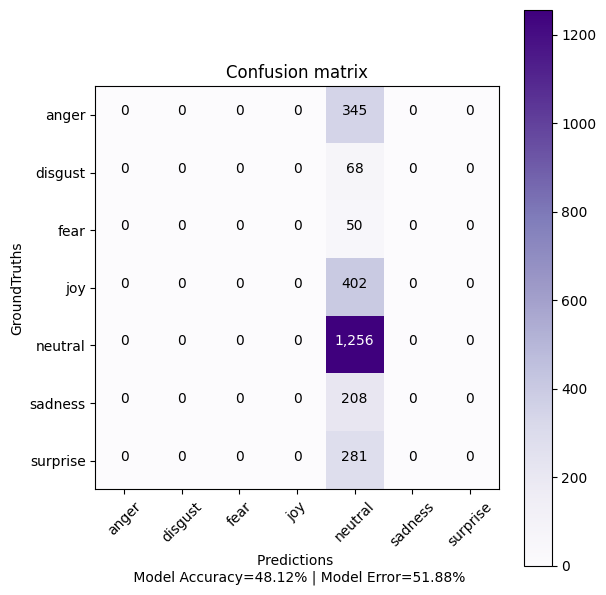

In [ ]:
cm = confusion_matrix(y_test_encoded, y_pred)
cr = ClassificationReport()
cr.plot_confusion_matrix(cm=cm, normalize = False, target_names = class_names_encoded)